In [4]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")


In [ ]:
train_root_path =r'C:\Users\praga\Downloads\EDGE MATRIX\retina\train'
test_root_path =r'C:\Users\praga\Downloads\EDGE MATRIX\retina\test'
validation_path=r'C:\Users\praga\Downloads\EDGE MATRIX\retina\valid'

In [ ]:
# Classes we have in our data set.
total_classes = os.listdir(r'C:\Users\praga\Downloads\EDGE MATRIX\retina\train')
total_classes

['DR', 'No_DR']

In [ ]:
# Total number of images per class.
images_path = Path(r'C:\Users\praga\Downloads\EDGE MATRIX\retina\train')

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* DR = 1050 images
* No_DR = 1026 images


## Data Preprocessing

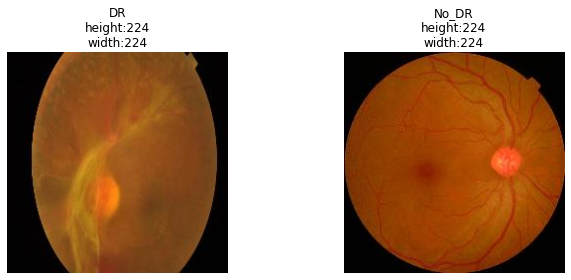

In [ ]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):

  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show();

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True,
rescale=1./255
)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 2076 files belonging to 2 classes.
Using 1661 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 2076 files belonging to 2 classes.
Using 415 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['DR', 'No_DR']


## Visualize the data

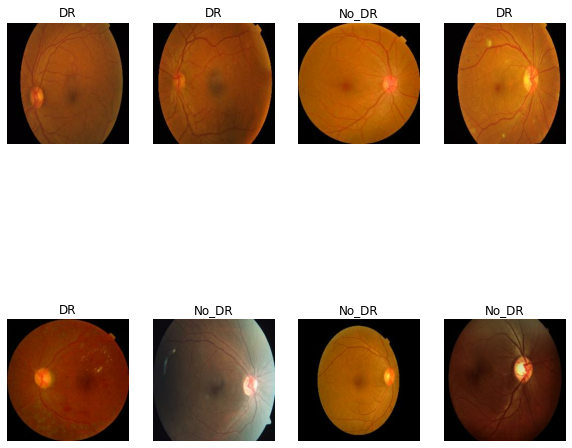

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


## Configure the data for higher performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalizing the dataset

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 1.0


## Build the Model

In [5]:
from tensorflow.keras import layers, models

num_classes = len(class_names)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


NameError: name 'class_names' is not defined

## Compile the Model

In [ ]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [ ]:
## Checking the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

## Train the Model

In [ ]:
epochs = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/30
52/52 [==============================] - 7s 107ms/step - loss: 2.9049 - accuracy: 0.8242 - val_loss: 25.0585 - val_accuracy: 0.5157
Epoch 2/30
52/52 [==============================] - 5s 99ms/step - loss: 0.3262 - accuracy: 0.8555 - val_loss: 30.7403 - val_accuracy: 0.5157
Epoch 3/30
52/52 [==============================] - 5s 103ms/step - loss: 0.2769 - accuracy: 0.8615 - val_loss: 33.0943 - val_accuracy: 0.5157
Epoch 4/30
52/52 [==============================] - 6s 117ms/step - loss: 0.2651 - accuracy: 0.8940 - val_loss: 31.2342 - val_accuracy: 0.5157
Epoch 5/30
52/52 [==============================] - 6s 113ms/step - loss: 0.2504 - accuracy: 0.8989 - val_loss: 26.5660 - val_accuracy: 0.5157
Epoch 6/30
52/52 [==============================] - 6s 111ms/step - loss: 0.2585 - accuracy: 0.9103 - val_loss: 21.0910 - val_accuracy: 0.5157
Epoch 7/30
52/52 [==============================] - 6s 112ms/step - loss: 0.2649 - accuracy: 0.9061 - val_loss: 18.6306 - val_accuracy: 0.5181


## Visualizing the results

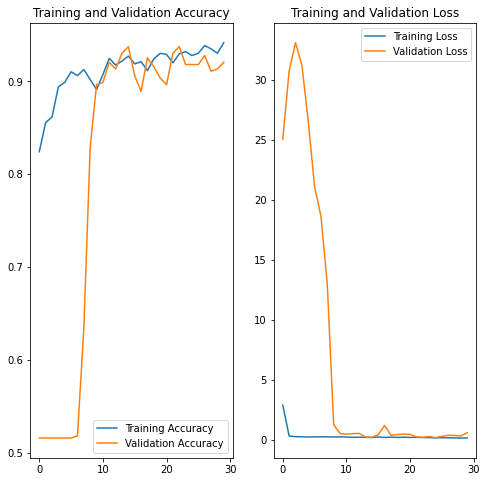

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Applying data augmentation

In [ ]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

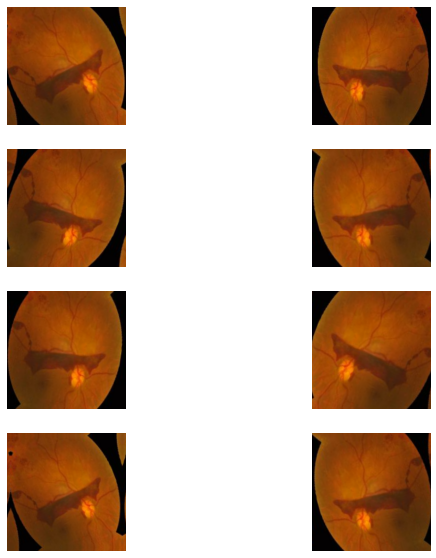

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)       

In [ ]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
52/52 [==============================] - 5s 76ms/step - loss: 0.4782 - accuracy: 0.7953 - val_loss: 0.2328 - val_accuracy: 0.9060
Epoch 2/20
52/52 [==============================] - 4s 75ms/step - loss: 0.2124 - accuracy: 0.9205 - val_loss: 0.2055 - val_accuracy: 0.9084
Epoch 3/20
52/52 [==============================] - 4s 75ms/step - loss: 0.1972 - accuracy: 0.9290 - val_loss: 0.1964 - val_accuracy: 0.9229
Epoch 4/20
52/52 [==============================] - 5s 89ms/step - loss: 0.1898 - accuracy: 0.9380 - val_loss: 0.2116 - val_accuracy: 0.9349
Epoch 5/20
52/52 [==============================] - 6s 117ms/step - loss: 0.1779 - accuracy: 0.9422 - val_loss: 0.1875 - val_accuracy: 0.9349
Epoch 6/20
52/52 [==============================] - 6s 117ms/step - loss: 0.1760 - accuracy: 0.9428 - val_loss: 0.1944 - val_accuracy: 0.9253
Epoch 7/20
52/52 [==============================] - 5s 89ms/step - loss: 0.1655 - accuracy: 0.9434 - val_loss: 0.1966 - val_accuracy: 0.9277
Epoch 8/20


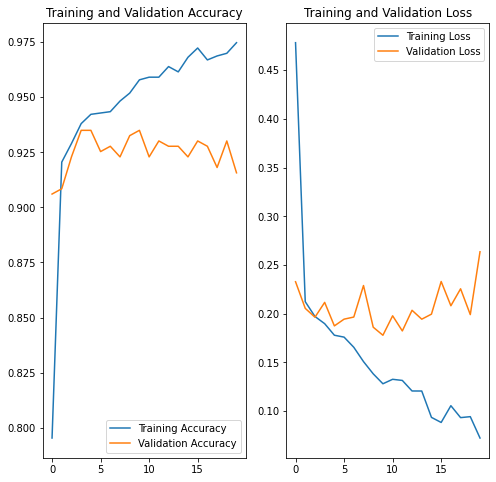

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the model

In [ ]:
# Save the Keras model as an HDF5 file
model.save("EDGEmodel.h5")

In [ ]:
# Save the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the saved image
from IPython.display import Image
Image(filename='model_architecture.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


FileNotFoundError: [Errno 2] No such file or directory: 'model_architecture.png'

In [1]:
# Create the model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile the model using Adam optimizer without weight_decay
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend = True)

NameError: name 'Sequential' is not defined

In [ ]:
pip install pydot graphviz


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tensorflow.keras.utils import plot_model


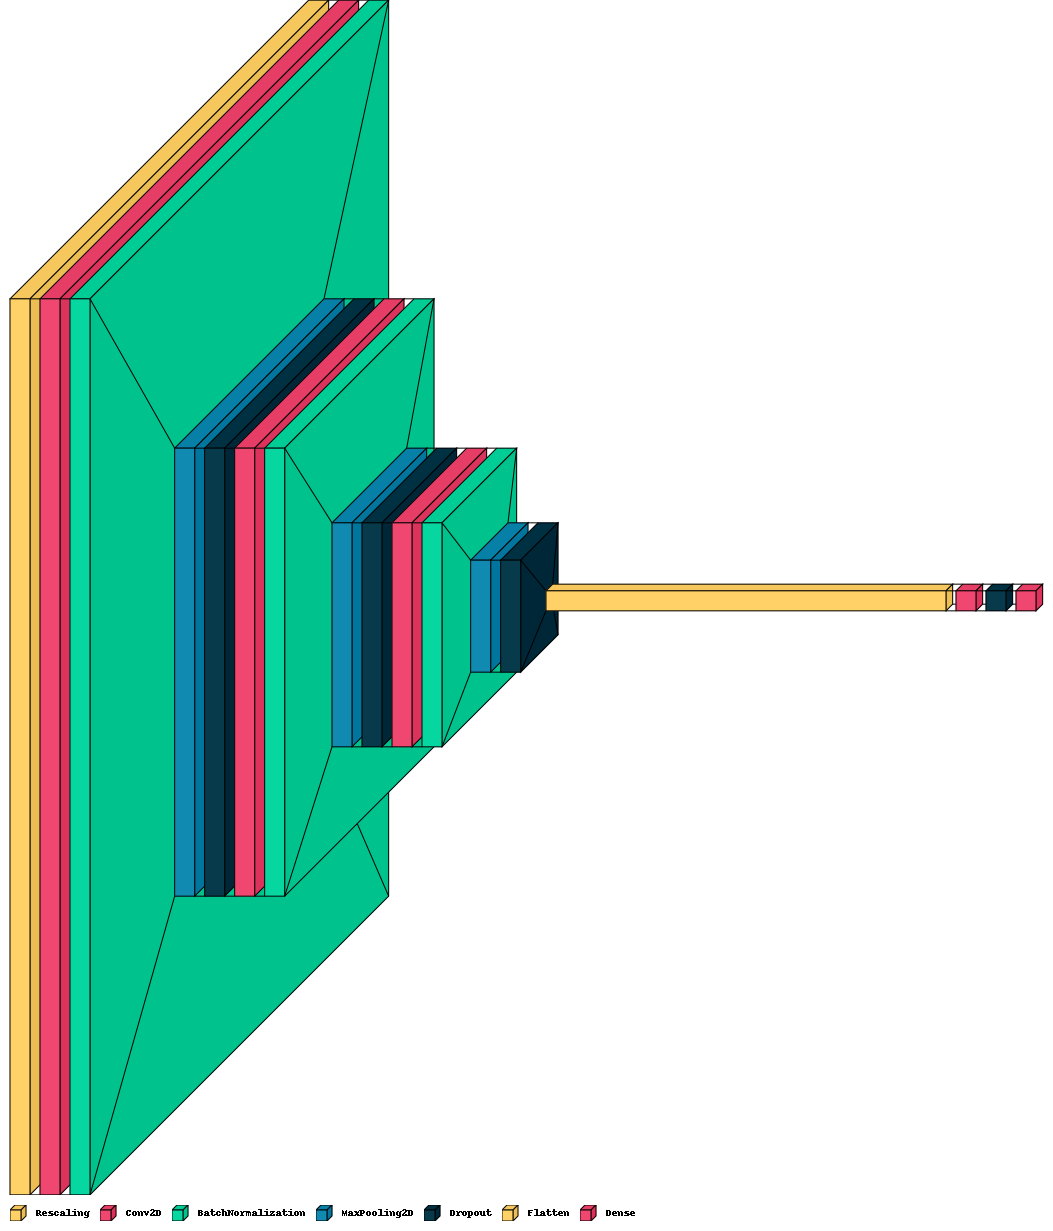

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend = True)

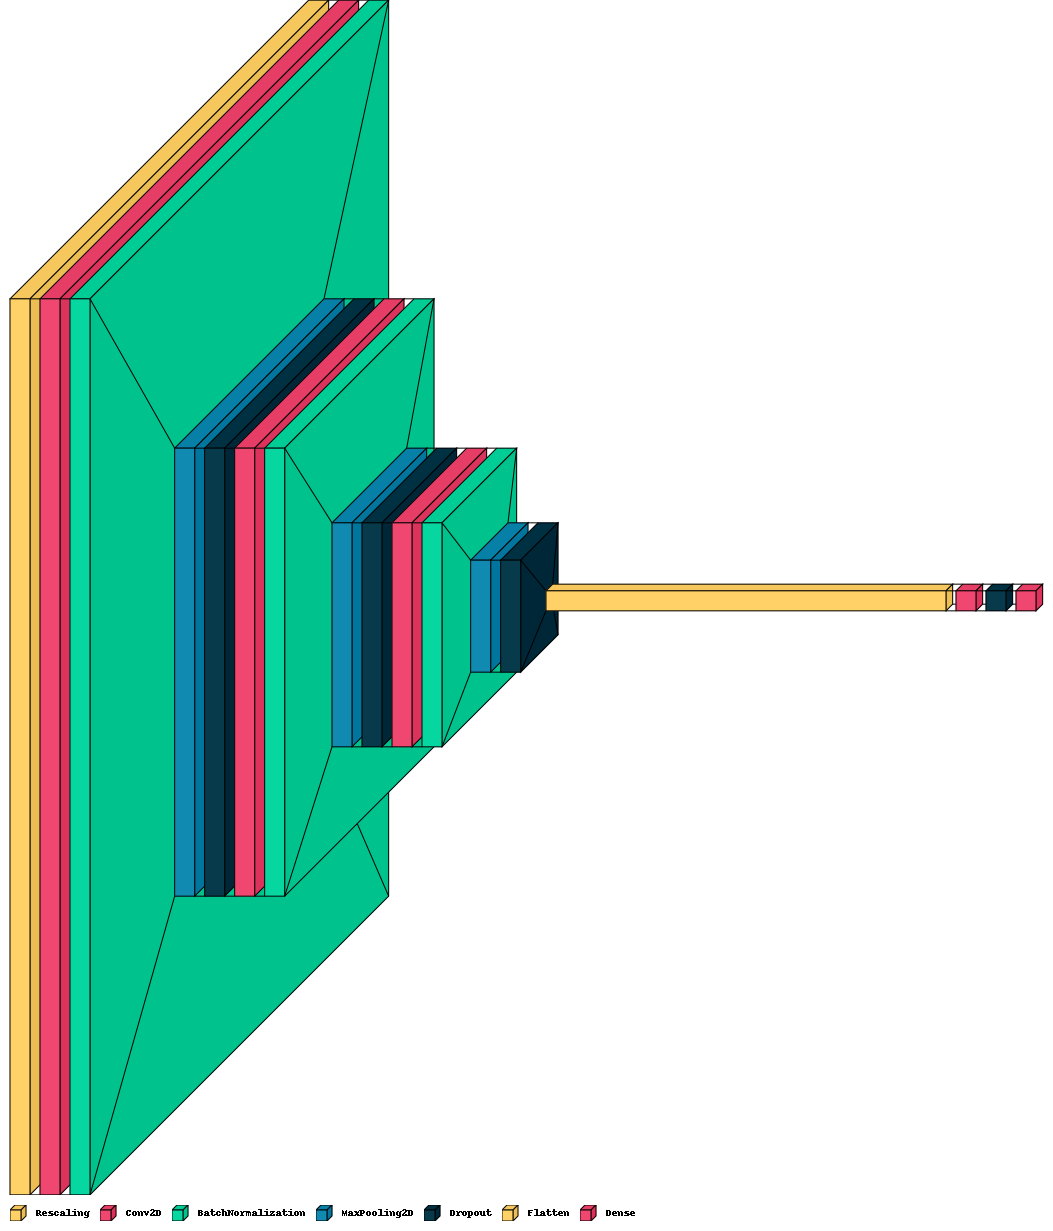

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend = True)

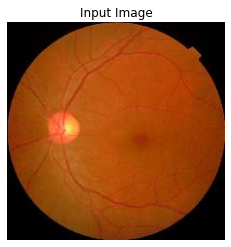

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array
def display_image(img_path):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

img_path = r'C:\Users\praga\OneDrive\Desktop\eye1.jpg'
display_image(img_path)
input_image = preprocess_image(img_path, target_size=(224, 224))



In [ ]:
# Predict the class
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions[0])

print(f'Predicted class: {predicted_class}')
print(f'Predicted label:{class_names[predicted_class]}')


Predicted class: 1
Predicted label:No_DR


In [6]:
# Create the model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile the model using Adam optimizer without weight_decay
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend = True)

NameError: name 'Dense' is not defined

In [7]:
# Import required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Create the model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))  # Adjust `number_of_classes` as needed

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


NameError: name 'train_x' is not defined